# Data Loading

In [ ]:
!echo pip freeze > requirements.txt

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
NBA_BOX_SCORE_ZIP_PATH = "/content/drive/MyDrive/Intro_Data_Science_Project/data/NBA_Boxscores.zip"

!unzip "{NBA_BOX_SCORE_ZIP_PATH}"

Archive:  /content/drive/MyDrive/Intro_Data_Science_Project/data/NBA_Boxscores.zip
  inflating: Games.csv               
  inflating: LeagueSchedule24_25.csv  
  inflating: NBA_Database.sql        
  inflating: PlayerStatistics.csv    
  inflating: Players.csv             
  inflating: TeamHistories.csv       
  inflating: TeamStatistics.csv      


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import os

In [6]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

# Player Statistics (Christian & Sven)

## Playground


In [12]:
player_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "get_data/game_logs_players_all.csv"))

C:\Users\trist\AppData\Local\Temp\ipykernel_27044\3904134166.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  player_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "get_data/game_logs_players_all.csv"))


In [13]:
rows_before_cleaning = len(player_statistics_df)
print(f"Rows before cleaning:   {rows_before_cleaning:,}")

Rows before cleaning:   454,156


In [14]:
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in player_statistics_df.columns:
    dtype = player_statistics_df[col].dtype
    missing = player_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = player_statistics_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = player_statistics_df[col].min()
        max_val = player_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")


Detailed column overview:

| gameId                         |      int64 | Range: 20000001 to 29901189                                                      | Missing:          0 |
| teamId                         |      int64 | Range: 1610612737 to 1610612766                                                  | Missing:          0 |
| playerteamName                 |     object | Examples: ['Cavaliers', 'Bullets', 'Pacers']                                     | Missing:          0 |
| playerteamTricode              |     object | Examples: ['CLE', 'WAS', 'IND']                                                  | Missing:          0 |
| playerteamCity                 |     object | Examples: ['Cleveland', 'Washington', 'Indiana']                                 | Missing:          0 |
| playerteamSlug                 |     object | Examples: ['cavaliers', 'bullets', 'pacers']                                     | Missing:          0 |
| opponentTeamId                 |      int64 | Range: 

**firstName, lastName** First and last name of the player

**personId**	Player's unique ID

**gameId**	Unique ID of the game, needed for joins

**gameDate**	Date and time of the game
Imported as object -> better to convert to datetime

**playerteamCity**  Indicates the city of the team the player played for in that game (e.g., Los Angeles → Lakers)

**opponentteamCity**  City of the opposing team (e.g., San Francisco → Warriors)

**gameType**	Type of game (Regular Season, Playoffs, Preseason), can be useful for segmentation

**gameLabel** An event- or competition-related label used to mark special games or tournaments. Examples:

"NBA Paris Games" → International game in Paris

"Emirates NBA Cup" → Game within the new In-Season Tournament

"NBA Mexico City Game" → Game in Mexico City

**gameSubLabel**	An additional label – used within playoffs or tournaments, e.g.:

"Championship" → Final game

"West Semifinal" → Western Conference Semifinals

"East Semifinal" → Eastern Conference Semifinals

There are many missing values for gameLabel and gameSubLabel, as these labels are only applied to “special” games → can be relevant for specific research questions focusing on those games

**seriesGameNumber**	Indicates which game number it is within a specific playoff series (Best-of-7 format).
Series only exist during the playoffs → In the regular season, this value is NaN

**win** 1 = Player’s team won, 0 = lost, classification target

**home**	1 = Home game, 0 = Away game, relevant for home-court advantage analysis

**numMinutes**	Player’s minutes played, negative values -> errors (needs cleaning)

**points**	Total points scored by the player in the specific game

**assists**	Number of assists (passes leading to a score)

**blocks**	Number of opponent shots blocked

**steals**	Number of times the player stole the ball from the opponent

**fieldGoalsAttempted**	Field goal attempts (2-pointers and 3-pointers) –> all shot attempts excluding free throws

**fieldGoalsMade**	Field goals made

**fieldGoalsPercentage**	Field goal shooting percentage (normally 0–1 – here values up to 9?) → possibly wrongly scaled –> needs verification

**threePointersAttempted, Made, Percentage**	Attempts, makes, and shooting percentage for 3-point shots Percentage looks plausible (0–1 range)

**freeThrowsAttempted, Made, Percentage**	Free throws - attempts, makes, percentage. freeThrowsPercentage goes up to 11 –> should be 0–1 → probably scaling error

**reboundsDefensive, reboundsOffensive, reboundsTotal**
Rebounds split into defensive, offensive, and total

Defensive rebounds = after missed opponent shots

Offensive rebounds = after missed own shots

reboundsTotal = sum of both

**foulsPersonal** Personal fouls committed by the player in the game
NBA rules allow max. 6 fouls per player before disqualification
→ Values up to 23 in the dataset likely indicate errors → should be checked

**turnovers** Number of turnovers (e.g., bad passes, traveling, opponent steals)
Important metric for evaluating efficiency and decision-making – high turnover count = generally negative

**plusMinusPoints** Point differential while the player was on the court: team score minus opponent score
Example: Player plays 25 minutes, during which his team scores 60 and opponent 50 → plusMinusPoints = +10
Positive values = positive impact, even without scoring many points

In [17]:
def convert_minutes(time_str):
    if pd.isna(time_str) or time_str == '':
        return 0
    try:
        # Handle MM:SS format
        if ':' in str(time_str):
            minutes, seconds = time_str.split(':')
            return int(minutes)
        # Handle cases where it might already be a number
        else:
            return int(float(time_str))
    except:
        return 0
player_statistics_df['numMinutes'] = player_statistics_df['numMinutes'].apply(convert_minutes)

In [18]:
# 1. Minutes less than 0
# Convert min to int
minutes_neg = player_statistics_df[player_statistics_df['numMinutes'] < 0]

# 2. Field goal and free throw percentages greater than 1
fg_perc_invalid = player_statistics_df[player_statistics_df['fieldGoalsPercentage'] > 1]
ft_perc_invalid = player_statistics_df[player_statistics_df['freeThrowsPercentage'] > 1]

# 3. Personal fouls greater than 6
fouls_invalid = player_statistics_df[player_statistics_df['foulsPersonal'] > 6]

# 4. Rows with many NaNs in key stat columns
stat_cols = ['points', 'assists', 'blocks', 'steals', 'reboundsTotal']
mostly_nan_rows = player_statistics_df[player_statistics_df[stat_cols].isnull().sum(axis=1) >= 3]

print(f"Negative minutes: {len(minutes_neg)}")
print(f"FG% > 1: {len(fg_perc_invalid)}")
print(f"FT% > 1: {len(ft_perc_invalid)}")
print(f"Fouls > 6: {len(fouls_invalid)}")
print(f"Stat rows with >=3 NaNs: {len(mostly_nan_rows)}")

Negative minutes: 0
FG% > 1: 0
FT% > 1: 0
Fouls > 6: 1
Stat rows with >=3 NaNs: 0


Some field goal and free throw percentages are greater than 1.0,
which likely means they were entered as whole percentages (e.g., 75 instead of 0.75). These values are scaled down by dividing by 100 to convert them into proper proportions.

The 1219 NaNs in the stat columns correspond to players who were listed but did not play a single second → inactive → will be removed in the following step.

In [19]:
# 1. Remove rows with negative minutes
player_statistics_df = player_statistics_df[player_statistics_df['numMinutes'].fillna(0) >= 0]

# 2. Shooting percentages over 1 → divide by 100 (scale to 0–1 range)
player_statistics_df.loc[player_statistics_df['fieldGoalsPercentage'] > 1, 'fieldGoalsPercentage'] /= 100
player_statistics_df.loc[player_statistics_df['freeThrowsPercentage'] > 1, 'freeThrowsPercentage'] /= 100

# 3. Personal fouls greater than 6 → remove (not allowed in the NBA)
player_statistics_df = player_statistics_df[player_statistics_df['foulsPersonal'] <= 6]

# 4. Remove players with 0 or NaN minutes played → considered inactive
player_statistics_df = player_statistics_df[player_statistics_df['numMinutes'].fillna(0) > 0]

# 5. Convert gameDate to datetime format
player_statistics_df['gameDate'] = pd.to_datetime(player_statistics_df['gameDate'])

# Remove rows with missing names


rows_after_cleaning = len(player_statistics_df)
print(f"Rows after cleaning:  {rows_after_cleaning:,}")

Rows after cleaning:  304,172


In [20]:
print("Detailed column overview after cleaning:\n")
for col in player_statistics_df.columns:
    dtype = player_statistics_df[col].dtype
    missing = player_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = player_statistics_df[col].dropna().unique()[:3]  # Beispiele zeigen
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>15} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = player_statistics_df[col].min()
        max_val = player_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>15} | {r:<80} | Missing: {missing:>10} |")

Detailed column overview after cleaning:

| gameId                         |           int64 | Range: 20000001 to 29901189                                                      | Missing:          0 |
| teamId                         |           int64 | Range: 1610612737 to 1610612766                                                  | Missing:          0 |
| playerteamName                 |          object | Examples: ['Cavaliers', 'Bullets', 'Pacers']                                     | Missing:          0 |
| playerteamTricode              |          object | Examples: ['CLE', 'WAS', 'IND']                                                  | Missing:          0 |
| playerteamCity                 |          object | Examples: ['Cleveland', 'Washington', 'Indiana']                                 | Missing:          0 |
| playerteamSlug                 |          object | Examples: ['cavaliers', 'bullets', 'pacers']                                     | Missing:          0 |
| opponent

Rows before cleaning: 1,621,084

Rows after cleaning: 1,357,805

Removed rows: 263,279 → approx. 16.2% of all rows removed

In [21]:
# print all unique values for gameType
print("Unique values for gameType:")
print(player_statistics_df['gameType'].unique())

Unique values for gameType:
['Regular Season']


In [22]:
# divide data into the groups of the game type; 'Regular Season' 'Preseason' 'Playoffs' 'Play-in Tournament' 'NBA Cup' 'NBA Emirates Cup'
regular_season_df = player_statistics_df[player_statistics_df['gameType'] == 'Regular Season']
preseason_df = player_statistics_df[player_statistics_df['gameType'] == 'Preseason']
playoffs_df = player_statistics_df[player_statistics_df['gameType'] == 'Playoffs']
play_in_tournament_df = player_statistics_df[player_statistics_df['gameType'] == 'Play-in Tournament']
nba_cup_df = player_statistics_df[player_statistics_df['gameType'] == 'NBA Cup']
nba_emirates_cup_df = player_statistics_df[player_statistics_df['gameType'] == 'NBA Emirates Cup']

In [23]:
# print nr of entries for each of the groups (new df's)
print("Nr of entries for each of the groups (new df's):")
print("Regular Season:", len(regular_season_df))
print("Preseason:", len(preseason_df))
print("Playoffs:", len(playoffs_df))
print("Play-in Tournament:", len(play_in_tournament_df))
print("NBA Cup:", len(nba_cup_df))
print("NBA Emirates Cup:", len(nba_emirates_cup_df))

Nr of entries for each of the groups (new df's):
Regular Season: 304172
Preseason: 0
Playoffs: 0
Play-in Tournament: 0
NBA Cup: 0
NBA Emirates Cup: 0


In [24]:
# Extract comparable information
print("\nNBA Cup – gameDates & Type")
print(nba_cup_df[['gameDate', 'gameType', 'gameSubLabel']].drop_duplicates().sort_values('gameDate').head(10))

print("\nNBA Emirates Cup – gameDates & Type")
print(nba_emirates_cup_df[['gameDate', 'gameType', 'gameSubLabel']].drop_duplicates().sort_values('gameDate').head(10))


NBA Cup – gameDates & Type
Empty DataFrame
Columns: [gameDate, gameType, gameSubLabel]
Index: []

NBA Emirates Cup – gameDates & Type
Empty DataFrame
Columns: [gameDate, gameType, gameSubLabel]
Index: []


There is a mislabeling in the data for the game on 2023-12-09 –> it was actually the final of the tournament and should have been labeled under the NBA Emirates Cup in the gameType field. In the following we correct that.

The NBA Emirates Cup is the new In-Season Tournament introduced in 2023. Its goal is to make the regular season more exciting and to add an additional competitive format — similar to national cup competitions in soccer (e.g., the DFB-Pokal in Germany).

All group stage games of the Emirates Cup count towards the regular season standings.
Only the semifinals and final are additional games (they do not count towards the regular season).

In [25]:
# Count the number of games per player (personId)
games_per_player = player_statistics_df['personId'].value_counts()

# Convert to a DataFrame and rename columns
games_per_player_df = games_per_player.reset_index()
games_per_player_df.columns = ['personId', 'numGames']

# Extract unique combinations of personId and player names
names_df = player_statistics_df[['personId', 'firstName', 'lastName']].drop_duplicates()

# Merge the game counts with the player names
games_with_names = games_per_player_df.merge(names_df, on='personId')

games_with_names.sort_values('numGames', ascending=False).head(10)

,personId,numGames,firstName,lastName
0,708,975,Kevin,Garnett
1,714,975,Michael,Finley
2,977,948,Kobe,Bryant
3,467,947,Jason,Kidd
4,965,946,Derek,Fisher
5,739,944,Rasheed,Wallace
6,951,942,Ray,Allen
7,959,926,Steve,Nash
8,1495,899,Tim,Duncan
9,1112,897,Ben,Wallace


In [ ]:
# drop firstName, lastName, gameDate, playerteamCity, playerteamName, opponentteamCity, opponentteamName,
# gameType, gameLabel, gameSubLabel, all *Attempted and *Made, home, , fouldsPersonal, reboundsDefensive,
# reboundsOffensive
#ps_df = regular_season_df.drop(columns=[
#    'firstName', 'lastName', 'gameDate', 'playerteamCity', 'playerteamName',
#    'opponentteamCity', 'opponentteamName', 'gameType', 'gameLabel',
#    'gameSubLabel', 'foulsPersonal', 'reboundsDefensive', 'reboundsOffensive',
#    'threePointersAttempted', 'threePointersMade',
#    'freeThrowsAttempted', 'freeThrowsMade', 'fieldGoalsAttempted', 'fieldGoalsMade',
#    'home'
#    ])

In [ ]:
#ps_df.info()

`playerId` is unique

In [26]:
# select form playoof_df only 100 random personIds
# set random seed to 42
np.random.seed(42)

selected_df = regular_season_df.sort_values(by=['personId'])
# sort by player id
selected_df.head()

# count unique values of player ids and print them per player id, print count desc
selected_df['personId'].value_counts()

# sort by count desc
selected_df['personId'].value_counts().sort_values(ascending=False)


personId
708       975
714       975
977       948
467       947
965       946
         ... 
201631      1
725         1
1954        1
2462        1
200984      1
Name: count, Length: 1297, dtype: int64

<Axes: ylabel='numMinutes'>

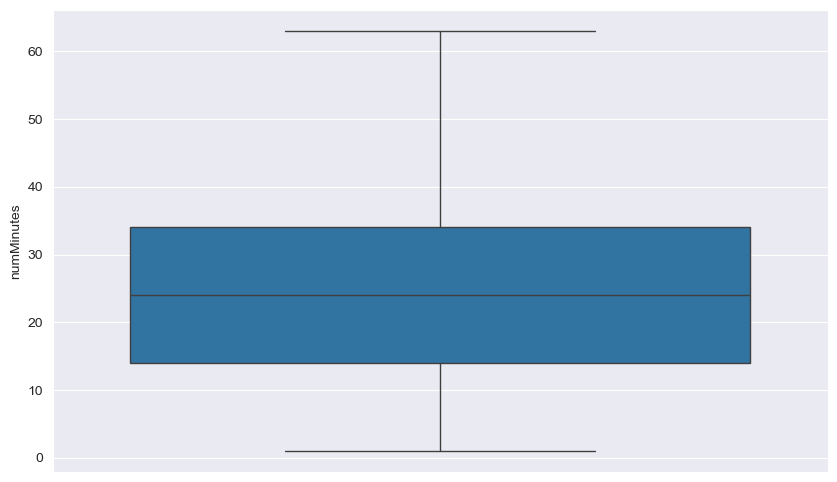

In [27]:
# boxplot of num minutes. in playoffs_df.
plt.figure(figsize=(10, 6))
sns.boxplot(y='numMinutes', data=selected_df)

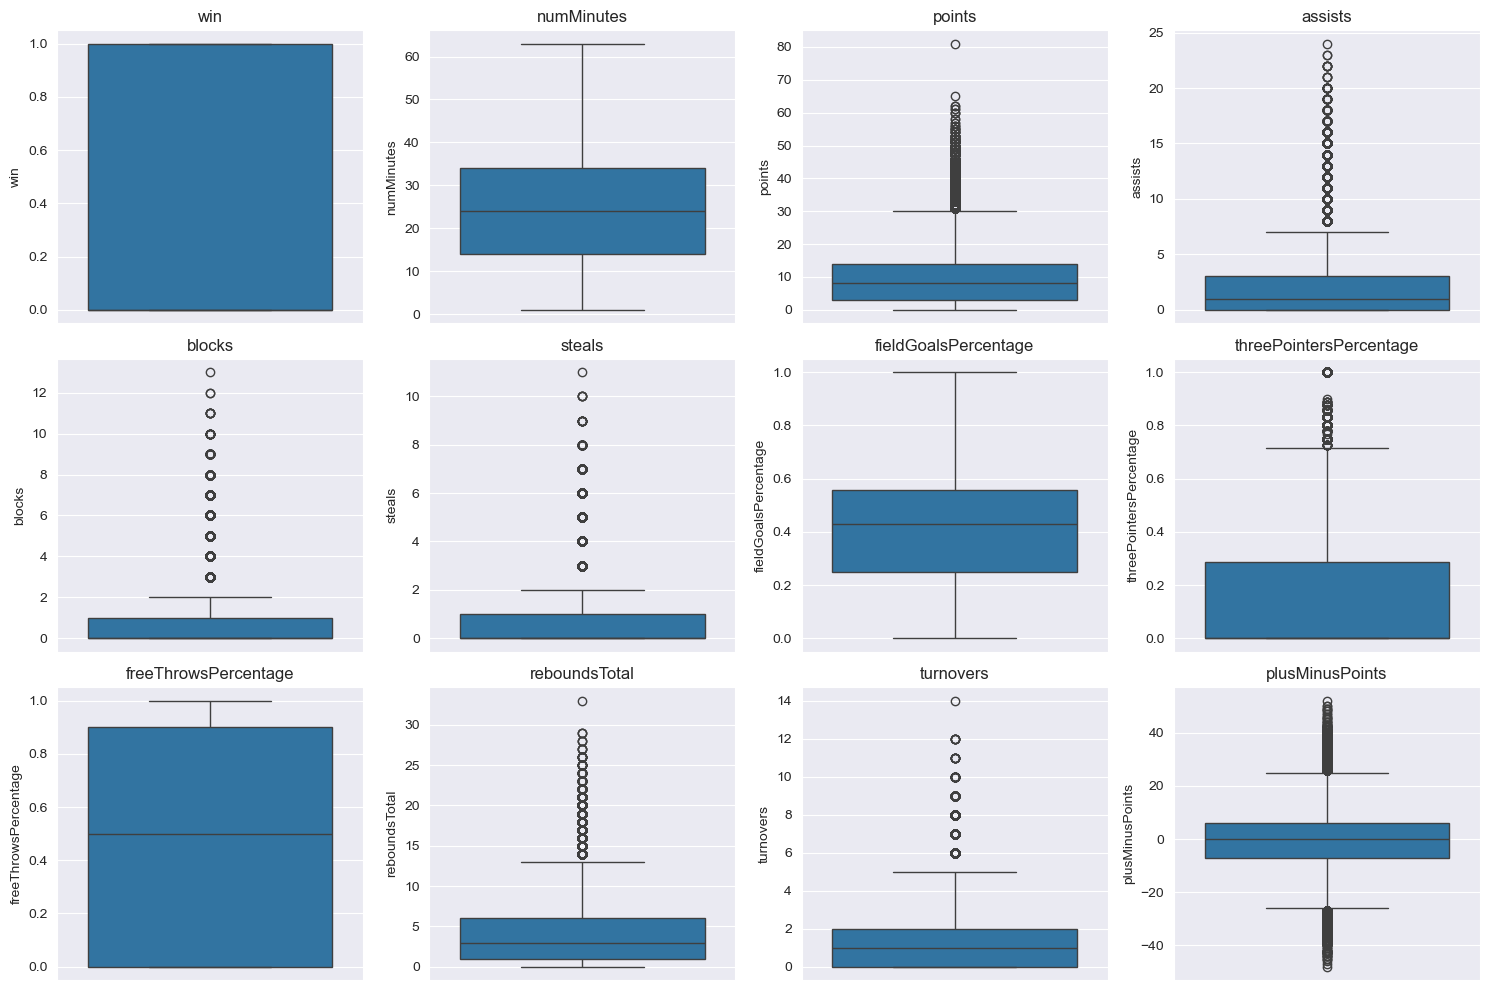

In [28]:
columns_to_plot = ['win', 'numMinutes', 'points', 'assists', 'blocks', 'steals', 'fieldGoalsPercentage', 'threePointersPercentage', 'freeThrowsPercentage', 'reboundsTotal', 'turnovers', 'plusMinusPoints']

# Create the boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=column, data=selected_df)
    plt.title(column)
plt.tight_layout()
plt.show()

In [29]:
# for "*percentage" columns, set values >1 to 1
for column in columns_to_plot:
    if column.endswith('Percentage'):
        selected_df.loc[selected_df[column] > 1, column] = 1

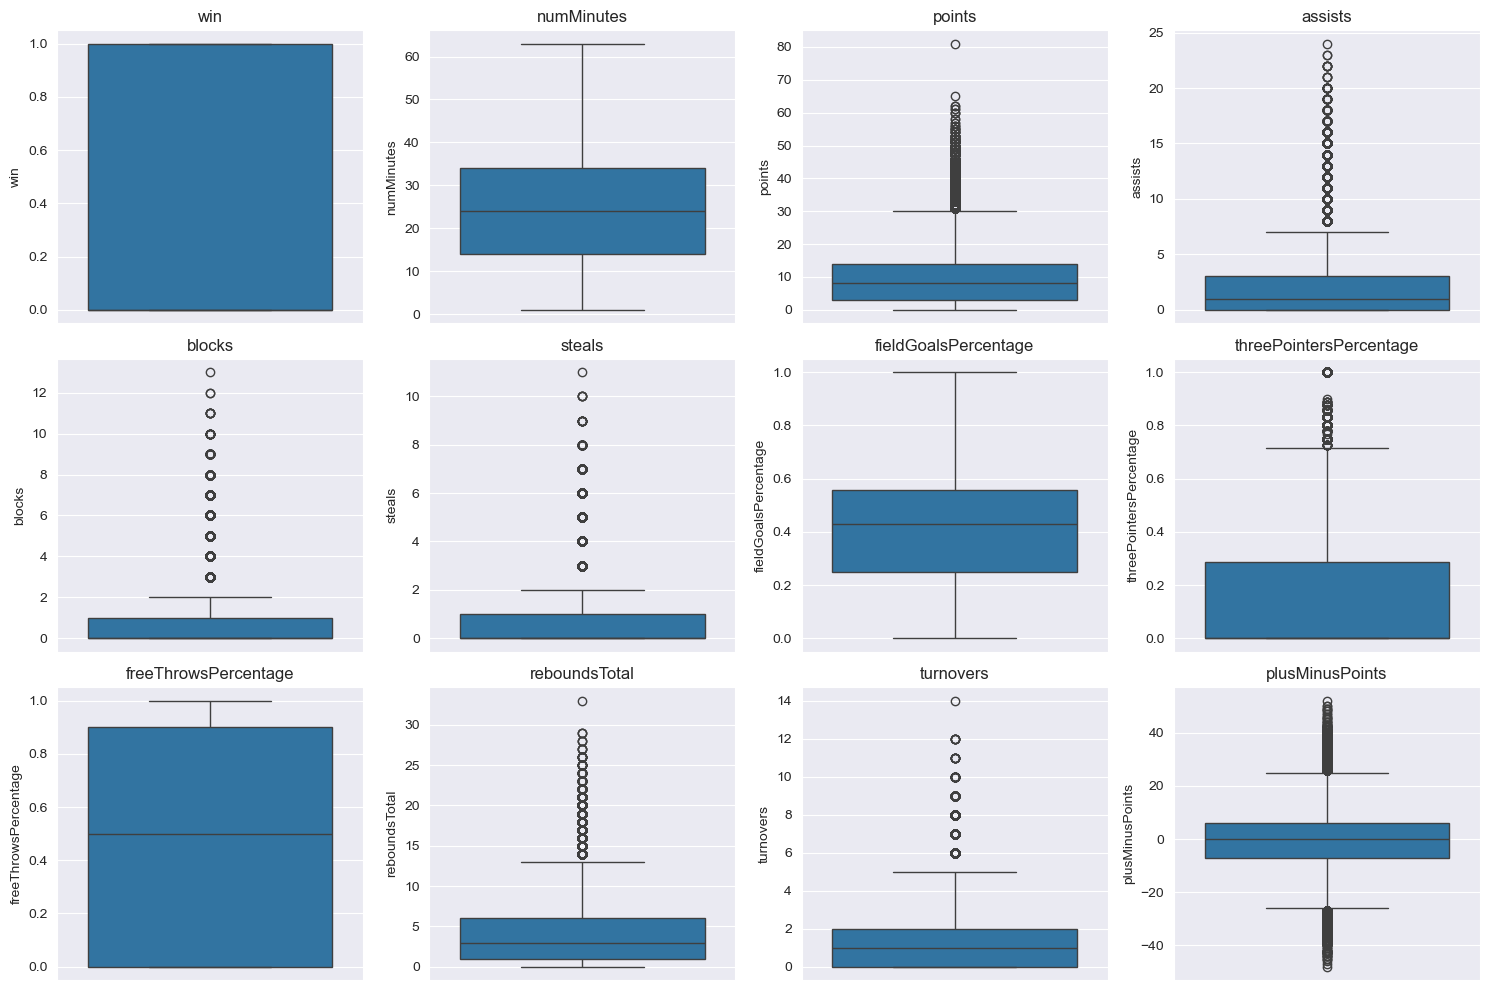

In [30]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=column, data=selected_df)
    plt.title(column)
plt.tight_layout()
plt.show()

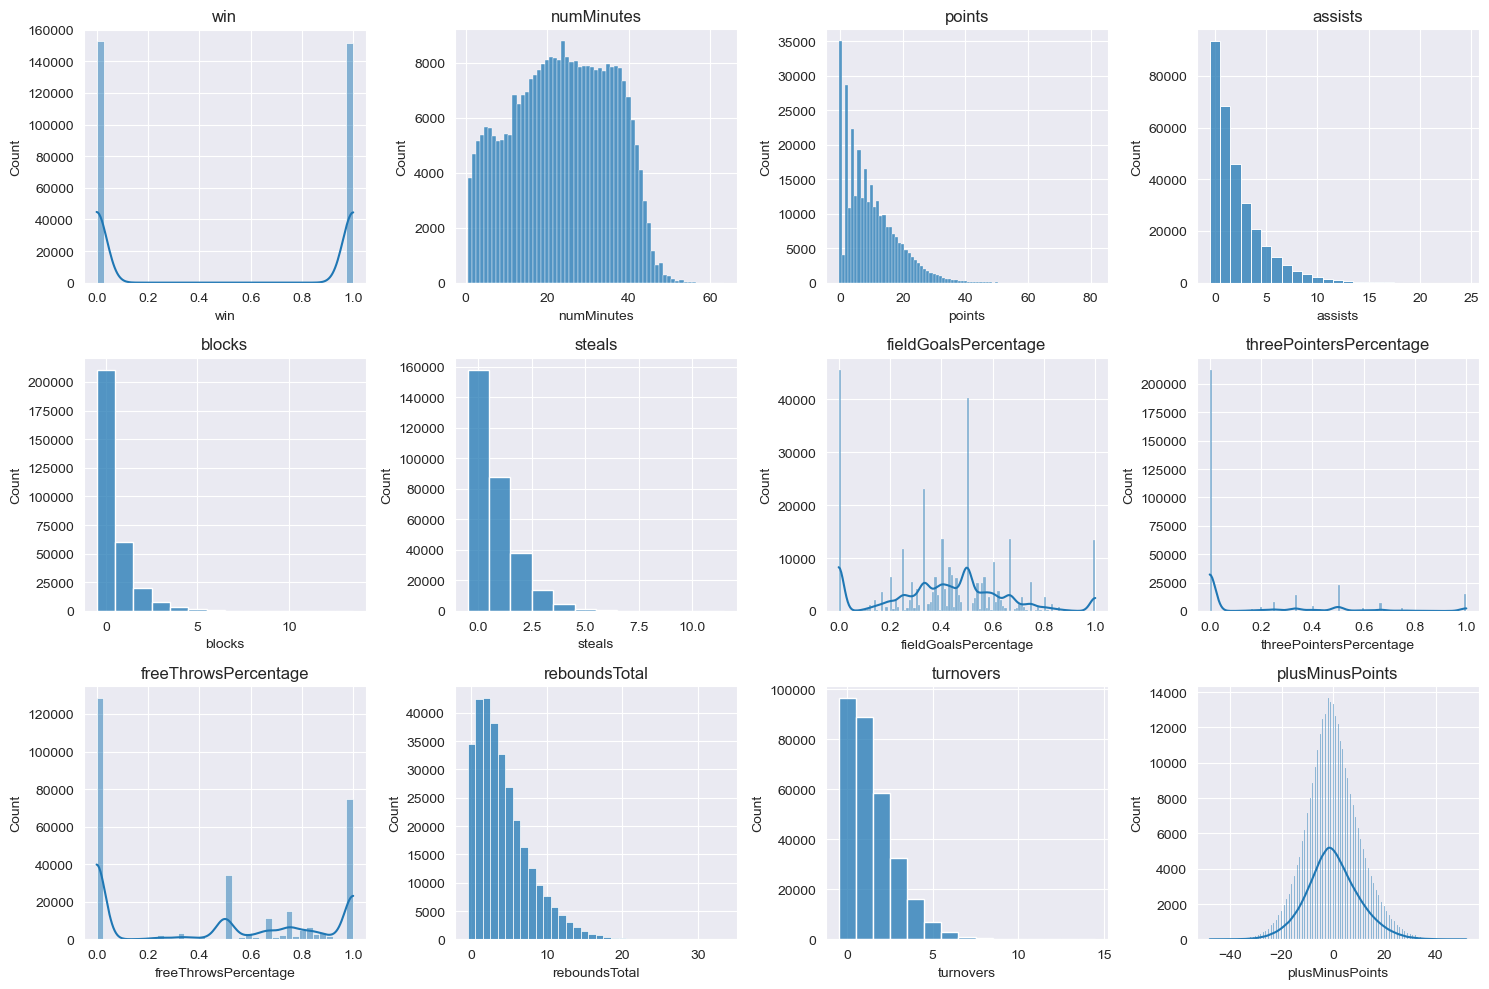

In [31]:
# prompt: same now for histograms. keep in mind that numMinutes, points, assists, blocks, steals, reboundsTotal, turnovers are integer discrete values.
# you can adjust:
# ```python
# plt.figure(figsize=(15, 10))
# for i, column in enumerate(columns_to_plot):
#     plt.subplot(3, 4, i + 1)
#     sns.histplot(playoffs_selected_df[column], kde=True)  # Added kde=True for kernel density estimation
#     plt.title(column)
# plt.tight_layout()
# plt.show()
# ```

# Create histograms
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(3, 4, i + 1)
    if column in ['numMinutes', 'points', 'assists', 'blocks', 'steals', 'reboundsTotal', 'turnovers']:
        sns.histplot(selected_df[column], kde=False, discrete=True) # Use discrete=True for integer data
    else:
        sns.histplot(selected_df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()


In [32]:
# make a pairplot on columns to plot
sns.pairplot(selected_df[columns_to_plot])


KeyboardInterrupt



Error in callback <function flush_figures at 0x000002A592D4D670> (for post_execute):



KeyboardInterrupt



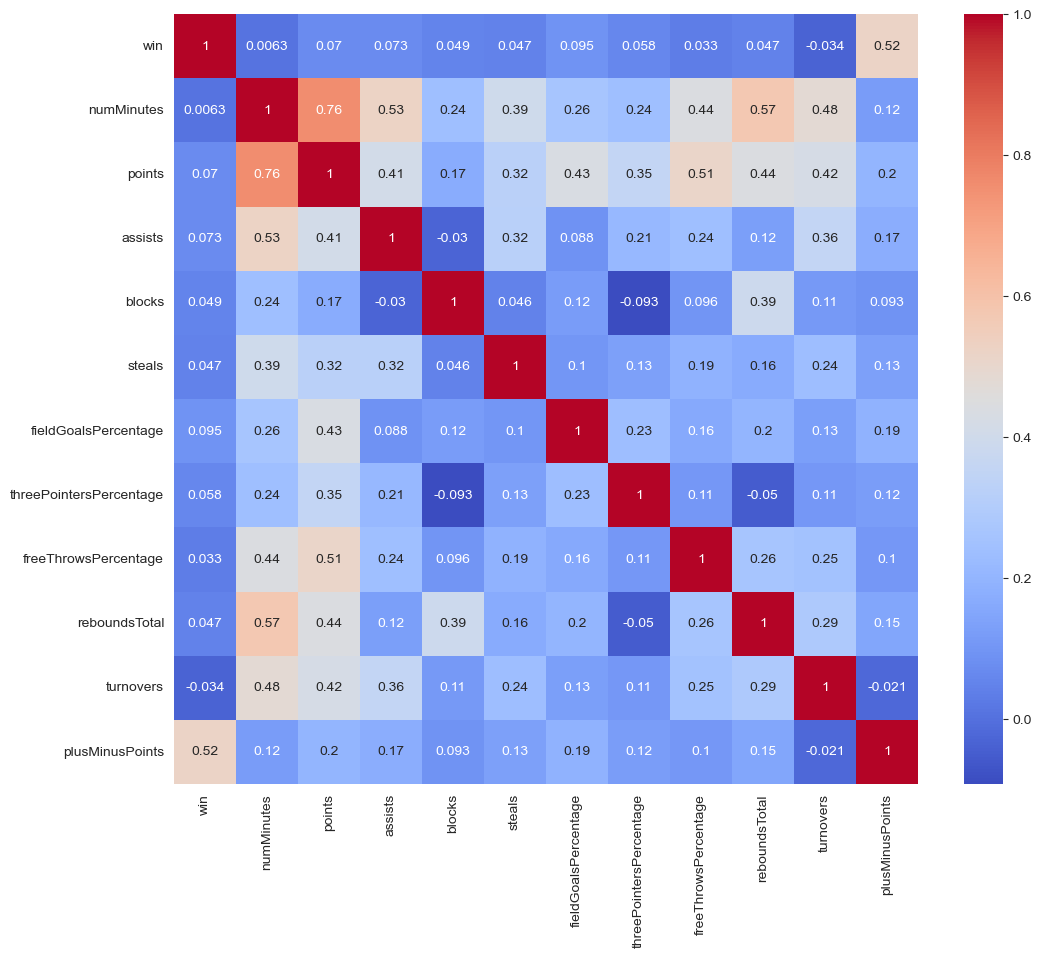

In [33]:
# a correlation matrix on columns to plot
plt.figure(figsize=(12, 10))
corr_matrix = selected_df[columns_to_plot].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [34]:
# Nur numerische Spalten auswählen
df_numeric = player_statistics_df.select_dtypes(include=np.number)

# Zielvariable 'win' extrahieren
y = df_numeric['win']

# Eingabe-Features: alle numerischen Spalten außer 'win'
X = df_numeric.drop(columns=['win'])

X = X.drop(columns=['personId', 'gameId', 'seriesGameNumber'])

KeyError: "['seriesGameNumber'] not found in axis"

In [ ]:
print(X.columns)
print(X.isna().sum())  # Gibt es fehlende Werte?

Index(['home', 'numMinutes', 'points', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints'],
      dtype='object')
home                       0
numMinutes                 0
points                     0
assists                    0
blocks                     0
steals                     0
fieldGoalsAttempted        0
fieldGoalsMade             0
fieldGoalsPercentage       0
threePointersAttempted     0
threePointersMade          0
threePointersPercentage    0
freeThrowsAttempted        0
freeThrowsMade             0
freeThrowsPercentage       0
reboundsDefensive          0
reboundsOffensive          0
reboundsTotal              0
foulsPersonal              0
turnovers

In [ ]:
# split into 80% Train and 20% Testset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# train decisiontree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix – Decision Tree (Player Wins)")
plt.show()

# Klassifikationsbericht
print("Classification Report – Decision Tree:")
print(classification_report(y_test, y_pred))

In [ ]:
# determine accuracy of prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

NOT GOOD ENOUGH... -> but also why do we already do a decision tree? based on what question? what goal? or just because it's fun?

In [ ]:
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance – Decision Tree (Player Wins)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Warum ist foulsPersonal so weit oben?

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["Loss", "Win"],
    filled=True,
    rounded=True,
    max_depth=3  # Optional: Nur die ersten 3 Ebenen anzeigen
)
plt.title("Visualization Decision Tree Classifiers")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest initialisieren und trainieren
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

y_pred_rf = rf.predict(X_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Confusion Matrix – Random Forest (Player Wins)")
plt.show()

# Klassifikationsbericht
print("Classification Report – Random Forest:")
print(classification_report(y_test, y_pred_rf))

In [ ]:
feat_imp_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp_rf.values, y=feat_imp_rf.index)
plt.title("Feature Importance – Random Forest (Player Wins)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Random forest performs better then the classical decision tree.

## PCA

In [ ]:
# get only numerical values of playoffs_df
playoffs_num_df = playoffs_df.select_dtypes(include=np.number)
# clean nan by replacing with 0
playoffs_num_df = playoffs_num_df.fillna(0)

# no personID or gameID or seriesGameNumber
playoffs_num_df = playoffs_num_df.drop(columns=['personId', 'gameId', 'seriesGameNumber'])

playoffs_num_df.info()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(playoffs_num_df)

In [ ]:
# prompt:
"""
regarding pca with UMAP in python. how can i determine the goodness of the pca if i want to find the best value for n_components?

[regarding pca:] how can i determine the name of the columns that are the two main components?
"""

# Check the PCA components
components = pca.components_
column_names = playoffs_num_df.columns

# Determine the main contributing features for each PCA component
main_features = {}
for i, component in enumerate(components):
    sorted_indices = component.argsort()[::-1]
    sorted_features = [(column_names[idx], component[idx]) for idx in sorted_indices]
    main_features[f'PCA Component {i+1}'] = sorted_features

# Display the main features for each PCA component
for component, features in main_features.items():
    print(f"{component}:")
    for feature, contribution in features:
        print(f"  {feature}: {contribution:.4f}")

In [ ]:
# plot pca results
plt.scatter(
    pca_transformed_data[:, 0],
    pca_transformed_data[:, 1],
    c=playoffs_num_df['win'],
    cmap='Spectral'
)
plt.gca().set_aspect('equal', 'datalim')

In [ ]:
# apply pca to only use the two principal components, and save in new df
pca_df = pd.DataFrame(pca_transformed_data, columns=['PC1', 'PC2'])
pca_df.head()

In [ ]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pca_df, playoffs_num_df['win'], test_size=0.2, random_state=42
)

In [ ]:
from sklearn.linear_model import LogisticRegression


# fit a linear classification line in the reduced data
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

still bad, but was fun to see

### UMAP

In [ ]:
import umap

In [ ]:
model = umap.UMAP(n_components=2)
embedding = model.fit_transform(playoffs_num_df)

In [ ]:
# plot embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=playoffs_num_df['win'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

prompt:

do the following umap, but with n_components=3. also with a nice plot

```
model = umap.UMAP(n_components=2)
embedding = model.fit_transform(playoffs_num_df)
# plot embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=playoffs_num_df['win'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
```

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming playoffs_num_df is already defined and contains the data
model = umap.UMAP(n_components=3)
embedding = model.fit_transform(playoffs_num_df)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=playoffs_num_df['win'], cmap='Spectral')

# Add a color bar
plt.colorbar(sc)

# Set aspect ratio and labels
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D UMAP Embedding')

plt.show()


In [ ]:
# try different n_components
from sklearn.metrics import silhouette_score

n_max = 5
for n in range(2, n_max+1):
    model = umap.UMAP(n_components=n)
    embedding = model.fit_transform(playoffs_num_df)

    # shiluette score
    score = silhouette_score(embedding, playoffs_num_df['win'])
    print(f"Silhouette Score for n_components={n}: {score:>10.5f}")

score does not really improve

so probably n=2 is already enough. but pca (umap) does not really provide a benefit here

# Team Statistics (Tristan)

## Cleanup

In [19]:
team_statistics_df = pd.read_csv("/content/drive/MyDrive/Intro_Data_Science_Project/data/TeamStatistics.csv")
temp_player_statistics_df = pd.read_csv("/content/drive/MyDrive/Intro_Data_Science_Project/data/PlayerStatistics.csv")
#team_statistics_df = pd.read_csv("./../data/TeamStatistics.csv")
#temp_player_statistics_df = pd.read_csv("./..//data/PlayerStatistics.csv")

# Add gametype to the DF
game_type_df = temp_player_statistics_df[['gameId', 'gameType', 'gameSubLabel']].drop_duplicates()
team_statistics_df = team_statistics_df.merge(game_type_df, on='gameId', how='left')

# Include NBA Emirates Cup games, excluding the Championship Final (Dec 17, 2024) since they are part of the Regular Season
emirates_cup_non_final_df = team_statistics_df[
    (team_statistics_df['gameType'] == 'NBA Emirates Cup') &
    (team_statistics_df['gameSubLabel'] != 'Championship')
]
# Only have regular season games
team_statistics_df = team_statistics_df[team_statistics_df['gameType'] == 'Regular Season']
team_statistics_df = pd.concat([team_statistics_df, emirates_cup_non_final_df])
# remove any remaining Championship-labeled games (e.g. misclassified 2024 IST Final)
team_statistics_df = team_statistics_df[
    team_statistics_df['gameSubLabel'] != 'Championship'
].reset_index(drop=True)

# Drop unnecessary columns
team_statistics_df = team_statistics_df.drop(columns=['coachId', 'gameType', 'gameSubLabel'])

# Drop Advanced stats columns --> Too little sample size
team_statistics_df = team_statistics_df.drop(columns=['q1Points', 'q2Points', 'q3Points', 'q4Points', 'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges', 'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint', 'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins', 'seasonLosses'])

team_statistics_df.info()
team_statistics_df = team_statistics_df.dropna()
team_statistics_df.info()

# Remove entries where freeThrowPercentage > 1.0
team_statistics_df = team_statistics_df[team_statistics_df['freeThrowsPercentage'] <= 1.0]
team_statistics_df = team_statistics_df[team_statistics_df['fieldGoalsPercentage'] <= 1.0]
team_statistics_df = team_statistics_df[team_statistics_df['threePointersPercentage'] <= 1.0]
team_statistics_df.info()

# Save as csv
REGULAR_SEASON_CSV_PATH = "/content/drive/MyDrive/Intro_Data_Science_Project/data/regular_season_team_df.csv"
#REGULAR_SEASON_CSV_PATH = "./../data/regular_season_team_df.csv"
team_statistics_df.to_csv(REGULAR_SEASON_CSV_PATH, index=False)
team_statistics_df.info

C:\Users\trist\AppData\Local\Temp\ipykernel_24116\2446220202.py:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_player_statistics_df = pd.read_csv("./..//data/PlayerStatistics.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130918 entries, 0 to 130917
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   130918 non-null  int64  
 1   gameDate                 130918 non-null  object 
 2   teamCity                 130918 non-null  object 
 3   teamName                 130918 non-null  object 
 4   teamId                   130918 non-null  int64  
 5   opponentTeamCity         130918 non-null  object 
 6   opponentTeamName         130918 non-null  object 
 7   opponentTeamId           130918 non-null  int64  
 8   home                     130918 non-null  int64  
 9   win                      130918 non-null  int64  
 10  teamScore                130918 non-null  int64  
 11  opponentScore            130918 non-null  int64  
 12  assists                  97810 non-null   float64
 13  blocks                   92477 non-null   float64
 14  stea

<bound method DataFrame.info of           gameId             gameDate       teamCity   teamName      teamId  \
0       22401058  2025-03-26 22:00:00         Boston    Celtics  1610612738   
1       22401058  2025-03-26 22:00:00        Phoenix       Suns  1610612756   
2       22401057  2025-03-26 21:00:00         Denver    Nuggets  1610612743   
3       22401057  2025-03-26 21:00:00      Milwaukee      Bucks  1610612749   
4       22401054  2025-03-26 19:30:00       Brooklyn       Nets  1610612751   
...          ...                  ...            ...        ...         ...   
130913  22300005  2023-11-03 20:00:00  Oklahoma City    Thunder  1610612760   
130914  22300002  2023-11-03 19:30:00      Milwaukee      Bucks  1610612749   
130915  22300002  2023-11-03 19:30:00       New York     Knicks  1610612752   
130916  22300001  2023-11-03 19:00:00      Cleveland  Cavaliers  1610612739   
130917  22300001  2023-11-03 19:00:00        Indiana     Pacers  1610612754   

       opponentTeam

## EDA

In [35]:
#team_statistics_df = pd.read_csv("/content/TeamStatistics.csv")
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "get_data/game_logs_teams_all.csv"))
player_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "get_data/game_logs_players_all.csv"))

C:\Users\trist\AppData\Local\Temp\ipykernel_27044\2404678375.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  player_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "get_data/game_logs_players_all.csv"))


In [36]:
team_statistics_df.head()

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,opponentTeamId,opponentTeamCity,opponentTeamName,opponentTeamTricode,...,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,teamScore,plusMinusPoints,opponentScore,win
0,29601184,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1610612764,Washington,Bullets,WAS,...,36,22,8,6,8,20,81,-4.0,85.0,0
1,29601184,1610612764,Washington,Bullets,WAS,bullets,1610612739,Cleveland,Cavaliers,CLE,...,46,18,3,5,11,22,85,4.0,81.0,1
2,29601185,1610612754,Indiana,Pacers,IND,pacers,1610612765,Detroit,Pistons,DET,...,55,27,7,3,14,30,120,-4.0,124.0,0
3,29601185,1610612765,Detroit,Pistons,DET,pistons,1610612754,Indiana,Pacers,IND,...,37,19,6,4,12,25,124,4.0,120.0,1
4,29601187,1610612759,San Antonio,Spurs,SAS,spurs,1610612745,Houston,Rockets,HOU,...,46,21,5,5,8,21,99,-4.0,103.0,0


In [37]:
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in team_statistics_df.columns:
    dtype = team_statistics_df[col].dtype
    missing = team_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = team_statistics_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = team_statistics_df[col].min()
        max_val = team_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")

Detailed column overview:

| gameId                         |      int64 | Range: 20000001 to 29901189                                                      | Missing:          0 |
| teamId                         |      int64 | Range: 1610612737 to 1610612766                                                  | Missing:          0 |
| teamCity                       |     object | Examples: ['Cleveland', 'Washington', 'Indiana']                                 | Missing:          0 |
| teamName                       |     object | Examples: ['Cavaliers', 'Bullets', 'Pacers']                                     | Missing:          0 |
| teamTricode                    |     object | Examples: ['CLE', 'WAS', 'IND']                                                  | Missing:          0 |
| teamSlug                       |     object | Examples: ['cavaliers', 'bullets', 'pacers']                                     | Missing:          0 |
| opponentTeamId                 |      int64 | Range: 

Note that the Attribute `gameType` is missing. To fix this, we must add it from the `player_statistics_df`

In [38]:
team_statistics_df['gameType'] = 'Regular Season'

In [39]:
# Redo column description
team_statistics_df.head()
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in team_statistics_df.columns:
    dtype = team_statistics_df[col].dtype
    missing = team_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = team_statistics_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = team_statistics_df[col].min()
        max_val = team_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")

Detailed column overview:

| gameId                         |      int64 | Range: 20000001 to 29901189                                                      | Missing:          0 |
| teamId                         |      int64 | Range: 1610612737 to 1610612766                                                  | Missing:          0 |
| teamCity                       |     object | Examples: ['Cleveland', 'Washington', 'Indiana']                                 | Missing:          0 |
| teamName                       |     object | Examples: ['Cavaliers', 'Bullets', 'Pacers']                                     | Missing:          0 |
| teamTricode                    |     object | Examples: ['CLE', 'WAS', 'IND']                                                  | Missing:          0 |
| teamSlug                       |     object | Examples: ['cavaliers', 'bullets', 'pacers']                                     | Missing:          0 |
| opponentTeamId                 |      int64 | Range: 

Next up, we want to divide the data up into the different gametypes:

In [40]:
# print all unique values for gameType
print("Unique values for gameType:")
print(team_statistics_df['gameType'].unique())

Unique values for gameType:
['Regular Season']


In [41]:
# divide data into the groups of the game type; 'Regular Season' 'Preseason' 'Playoffs' 'Play-in Tournament' 'NBA Cup' 'NBA Emirates Cup'
regular_season_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Regular Season']
preseason_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Preseason']
playoffs_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Playoffs']
play_in_tournament_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Play-in Tournament']
nba_cup_team_df = team_statistics_df[team_statistics_df['gameType'] == 'NBA Cup']
nba_emirates_cup_team_df = team_statistics_df[team_statistics_df['gameType'] == 'NBA Emirates Cup']

In [42]:
# print nr of entries for each of the groups (new df's)
print("Nr of entries for each of the groups (new df's):")
print("Regular Season:", len(regular_season_team_df))
print("Preseason:", len(preseason_team_df))
print("Playoffs:", len(playoffs_team_df))
print("Play-in Tournament:", len(play_in_tournament_team_df))
print("NBA Cup:", len(nba_cup_team_df))
print("NBA Emirates Cup:", len(nba_emirates_cup_team_df))
regular_season_team_df.head()

Nr of entries for each of the groups (new df's):
Regular Season: 30396
Preseason: 0
Playoffs: 0
Play-in Tournament: 0
NBA Cup: 0
NBA Emirates Cup: 0


,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,opponentTeamId,opponentTeamCity,opponentTeamName,opponentTeamTricode,...,assists,steals,blocks,turnovers,foulsPersonal,teamScore,plusMinusPoints,opponentScore,win,gameType
0,29601184,1610612739,Cleveland,Cavaliers,CLE,cavaliers,1610612764,Washington,Bullets,WAS,...,22,8,6,8,20,81,-4.0,85.0,0,Regular Season
1,29601184,1610612764,Washington,Bullets,WAS,bullets,1610612739,Cleveland,Cavaliers,CLE,...,18,3,5,11,22,85,4.0,81.0,1,Regular Season
2,29601185,1610612754,Indiana,Pacers,IND,pacers,1610612765,Detroit,Pistons,DET,...,27,7,3,14,30,120,-4.0,124.0,0,Regular Season
3,29601185,1610612765,Detroit,Pistons,DET,pistons,1610612754,Indiana,Pacers,IND,...,19,6,4,12,25,124,4.0,120.0,1,Regular Season
4,29601187,1610612759,San Antonio,Spurs,SAS,spurs,1610612745,Houston,Rockets,HOU,...,21,5,5,8,21,99,-4.0,103.0,0,Regular Season


We will perform EDA on the Regular Season Dataset, and as a first step we will drop the unnecessary columns:
- `gameDate`
- `teamCity` (Can identify via `teamId`)
- `teamName` (Can identify via `teamId`)
- All Variables regarding `oppositeTeam` (The opposing team has their own record)
- `coachId` (Only NaN's)
- `gameType` (All are Regular Season)

In [45]:
reduced_regular_season_team_df = regular_season_team_df.drop(columns=[
    'gameDate', 'teamCity', 'teamName', 'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'gameType'
])
regular_season_team_df = regular_season_team_df.drop(columns=['gameType'])
reduced_regular_season_team_df.head()

,gameId,teamId,teamTricode,teamSlug,opponentTeamTricode,opponentTeamSlug,home,numMinutes,fieldGoalsMade,fieldGoalsAttempted,...,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,teamScore,plusMinusPoints,opponentScore,win
0,29601184,1610612739,CLE,cavaliers,WAS,bullets,1,240:00,34,76,...,36,22,8,6,8,20,81,-4.0,85.0,0
1,29601184,1610612764,WAS,bullets,CLE,cavaliers,0,240:00,33,75,...,46,18,3,5,11,22,85,4.0,81.0,1
2,29601185,1610612754,IND,pacers,DET,pistons,1,265:00,44,100,...,55,27,7,3,14,30,120,-4.0,124.0,0
3,29601185,1610612765,DET,pistons,IND,pacers,0,265:00,42,80,...,37,19,6,4,12,25,124,4.0,120.0,1
4,29601187,1610612759,SAS,spurs,HOU,rockets,1,240:00,39,86,...,46,21,5,5,8,21,99,-4.0,103.0,0


TODO: Drop NA or drop advaced stats columns?

In [46]:
# Drop rows with any NA values in the DataFrame.
reduced_regular_season_team_df.info()
reduced_regular_season_team_df = reduced_regular_season_team_df.dropna()
# Redo column description
reduced_regular_season_team_df.head()
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in reduced_regular_season_team_df.columns:
    dtype = reduced_regular_season_team_df[col].dtype
    missing = reduced_regular_season_team_df[col].isnull().sum()

    if dtype == 'object':
        example_values = reduced_regular_season_team_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = reduced_regular_season_team_df[col].min()
        max_val = reduced_regular_season_team_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30396 entries, 0 to 30395
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   30396 non-null  int64  
 1   teamId                   30396 non-null  int64  
 2   teamTricode              30396 non-null  object 
 3   teamSlug                 30396 non-null  object 
 4   opponentTeamTricode      30396 non-null  object 
 5   opponentTeamSlug         30396 non-null  object 
 6   home                     30396 non-null  int64  
 7   numMinutes               30396 non-null  object 
 8   fieldGoalsMade           30396 non-null  int64  
 9   fieldGoalsAttempted      30396 non-null  int64  
 10  fieldGoalsPercentage     30396 non-null  float64
 11  threePointersMade        30396 non-null  int64  
 12  threePointersAttempted   30396 non-null  int64  
 13  threePointersPercentage  30396 non-null  float64
 14  freeThrowsMade        

In [47]:
reduced_regular_season_team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30396 entries, 0 to 30395
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   30396 non-null  int64  
 1   teamId                   30396 non-null  int64  
 2   teamTricode              30396 non-null  object 
 3   teamSlug                 30396 non-null  object 
 4   opponentTeamTricode      30396 non-null  object 
 5   opponentTeamSlug         30396 non-null  object 
 6   home                     30396 non-null  int64  
 7   numMinutes               30396 non-null  object 
 8   fieldGoalsMade           30396 non-null  int64  
 9   fieldGoalsAttempted      30396 non-null  int64  
 10  fieldGoalsPercentage     30396 non-null  float64
 11  threePointersMade        30396 non-null  int64  
 12  threePointersAttempted   30396 non-null  int64  
 13  threePointersPercentage  30396 non-null  float64
 14  freeThrowsMade        

We can now perform some exploratory Boxplots and Pairplots on a subset of the Regular Season dataset (To speed up computation)

In [48]:
# Subset of Regular Season
sub_regular_season_team_df = reduced_regular_season_team_df.sample(n=10000, random_state=2)
sub_regular_season_team_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 26073 to 26563
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   10000 non-null  int64  
 1   teamId                   10000 non-null  int64  
 2   teamTricode              10000 non-null  object 
 3   teamSlug                 10000 non-null  object 
 4   opponentTeamTricode      10000 non-null  object 
 5   opponentTeamSlug         10000 non-null  object 
 6   home                     10000 non-null  int64  
 7   numMinutes               10000 non-null  object 
 8   fieldGoalsMade           10000 non-null  int64  
 9   fieldGoalsAttempted      10000 non-null  int64  
 10  fieldGoalsPercentage     10000 non-null  float64
 11  threePointersMade        10000 non-null  int64  
 12  threePointersAttempted   10000 non-null  int64  
 13  threePointersPercentage  10000 non-null  float64
 14  freeThrowsMade         

In [ ]:
# Pairplot
plt.figure(figsize=(40, 40))
sns.pairplot(sub_regular_season_team_df, hue='win', height=8)
plt.plot()

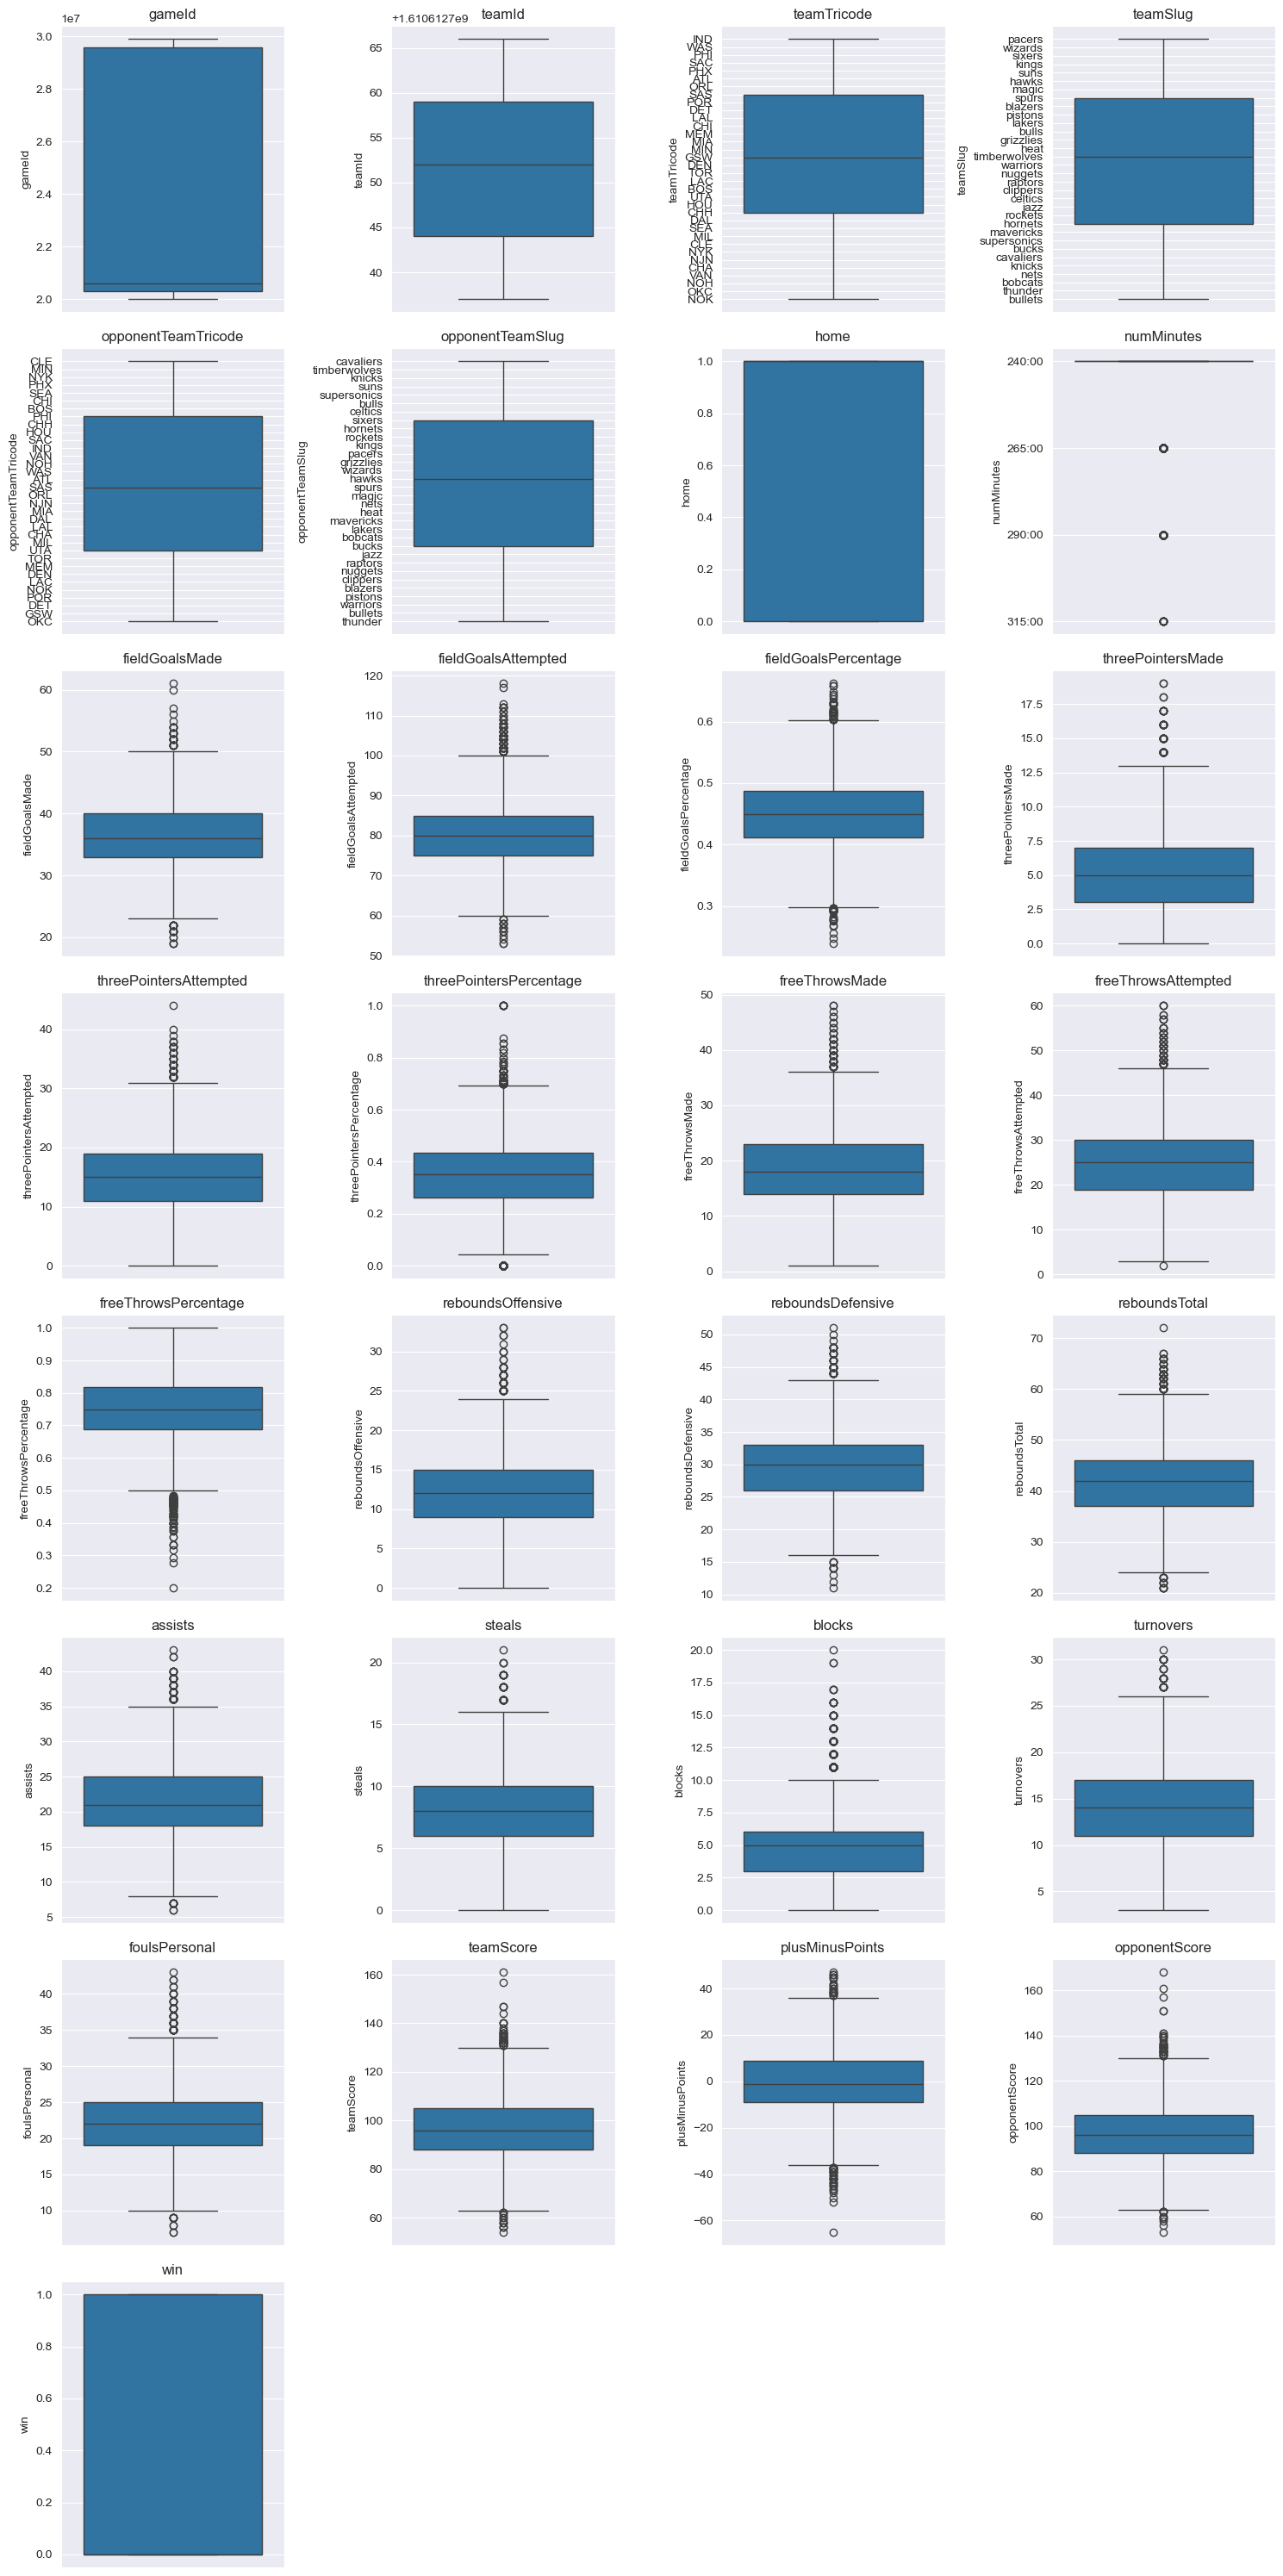

In [49]:
columns_to_plot = sub_regular_season_team_df.columns
# Create the boxplots
plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot) // 4 + 1, 4, i + 1)
    sns.boxplot(y=column, data=sub_regular_season_team_df)
    plt.title(column)
plt.tight_layout()
plt.show()

In [50]:
print(f"Nr. Entries before cleaning: {len(regular_season_team_df)}")

# Remove entries where freeThrowPercentage > 1.0
sub_regular_season_team_df = sub_regular_season_team_df[sub_regular_season_team_df['freeThrowsPercentage'] <= 1.0]
reduced_regular_season_team_df = reduced_regular_season_team_df[reduced_regular_season_team_df['freeThrowsPercentage'] <= 1.0]
regular_season_team_df = regular_season_team_df[regular_season_team_df['freeThrowsPercentage'] <= 1.0]


# While we are at it, we will clean all percentages just in case if the samples we have taken are not complete
sub_regular_season_team_df = sub_regular_season_team_df[sub_regular_season_team_df['fieldGoalsPercentage'] <= 1.0]
reduced_regular_season_team_df = reduced_regular_season_team_df[reduced_regular_season_team_df['fieldGoalsPercentage'] <= 1.0]
regular_season_team_df = regular_season_team_df[regular_season_team_df['fieldGoalsPercentage'] <= 1.0 ]

sub_regular_season_team_df = sub_regular_season_team_df[sub_regular_season_team_df['threePointersPercentage'] <= 1.0]
reduced_regular_season_team_df = reduced_regular_season_team_df[reduced_regular_season_team_df['threePointersPercentage'] <= 1.0]
regular_season_team_df = regular_season_team_df[regular_season_team_df['threePointersPercentage'] <= 1.0]

print(f"Nr. Entries after cleaning: {len(regular_season_team_df)}")
sub_regular_season_team_df.info()

Nr. Entries before cleaning: 30396
Nr. Entries after cleaning: 30396
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 26073 to 26563
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   10000 non-null  int64  
 1   teamId                   10000 non-null  int64  
 2   teamTricode              10000 non-null  object 
 3   teamSlug                 10000 non-null  object 
 4   opponentTeamTricode      10000 non-null  object 
 5   opponentTeamSlug         10000 non-null  object 
 6   home                     10000 non-null  int64  
 7   numMinutes               10000 non-null  object 
 8   fieldGoalsMade           10000 non-null  int64  
 9   fieldGoalsAttempted      10000 non-null  int64  
 10  fieldGoalsPercentage     10000 non-null  float64
 11  threePointersMade        10000 non-null  int64  
 12  threePointersAttempted   10000 non-null  int64  
 13  threePoi

In [62]:
columns_to_plot = sub_regular_season_team_df.columns
sub_regular_season_team_df.drop(['gameId', 'teamId', 'teamSlug', 'teamTricode', 'opponentTeamTricode', 'opponentTeamSlug'], inplace=True, axis=1)

KeyError: "['gameId', 'teamId', 'teamSlug', 'teamTricode', 'opponentTeamTricode', 'opponentTeamSlug'] not found in axis"

In [63]:
sub_regular_season_team_df['numMinutes'] = sub_regular_season_team_df['numMinutes'].apply(convert_minutes)


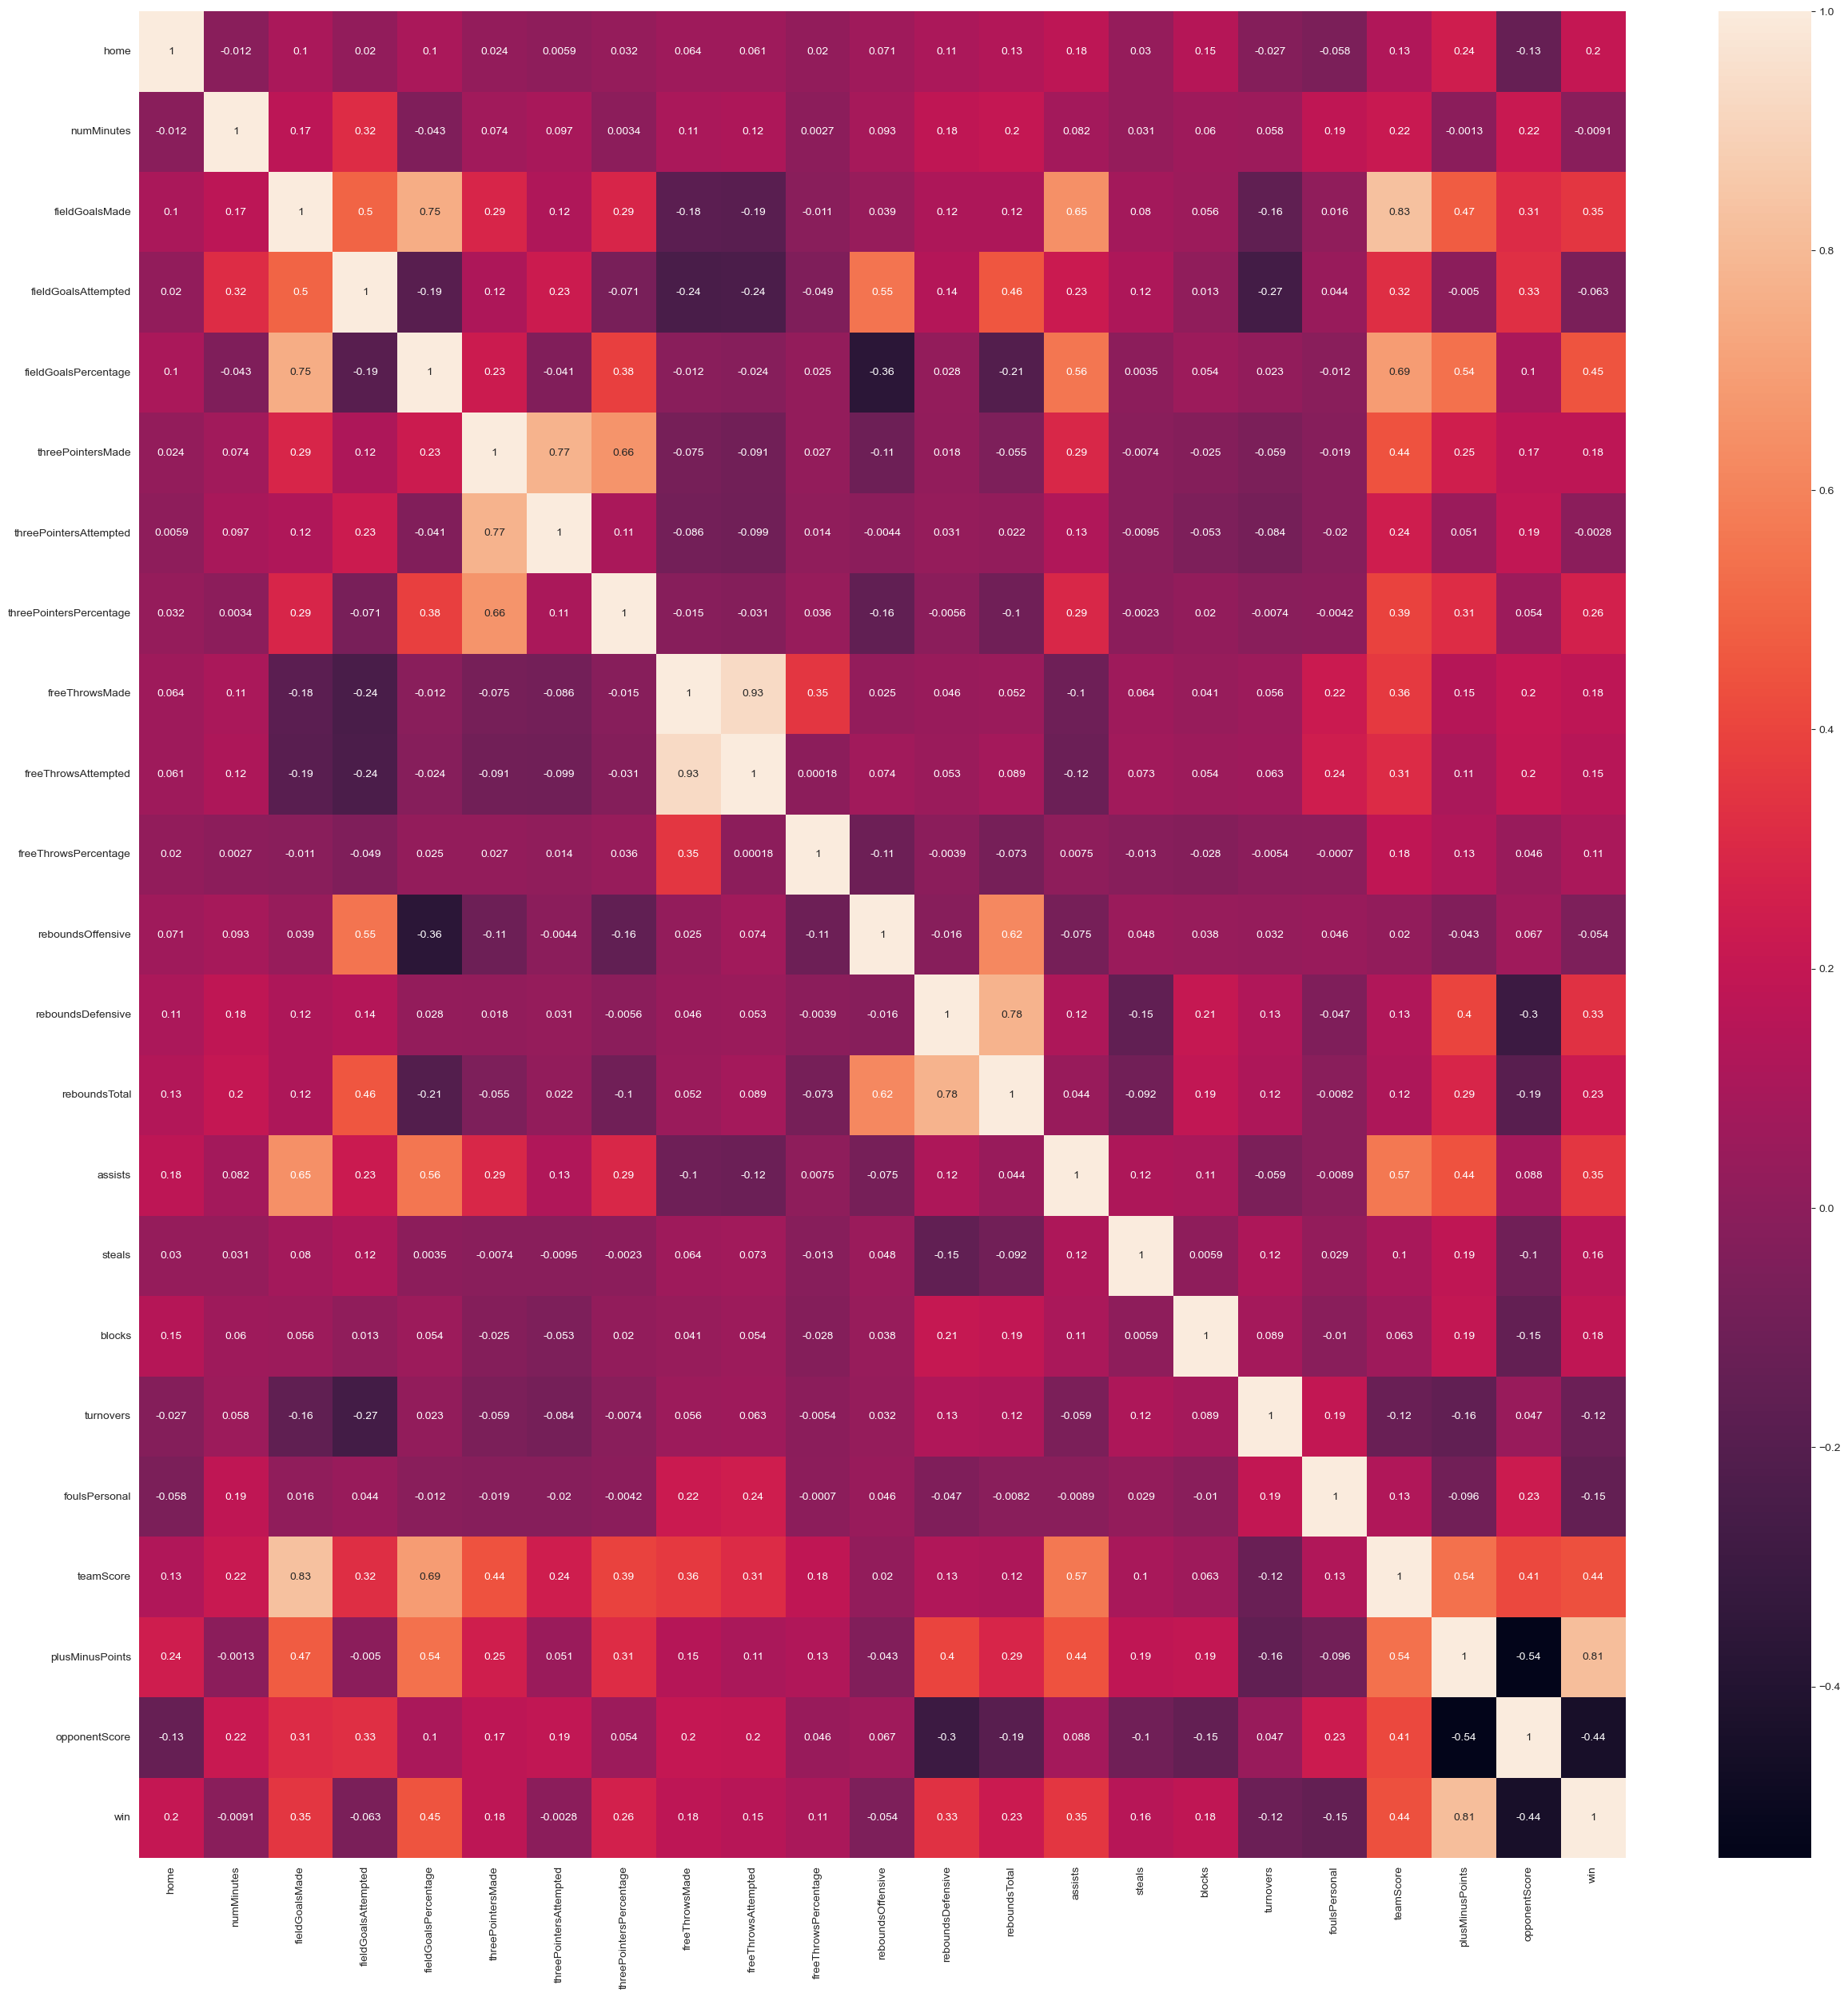

In [64]:
# a correlation matrix on columns to plot

corr_matrix = sub_regular_season_team_df[columns_to_plot].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [65]:
# Correlation matrix based on Distance Correlation
import dcor

# Calculate the distance correlation matrix for the DataFrame
columns = [
    "home",
    "win",
    "teamScore",
    "opponentScore",
    "assists",
    "blocks",
    "steals",
    "fieldGoalsAttempted",
    "fieldGoalsMade",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersMade",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsMade",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsOffensive",
    "reboundsTotal",
    "foulsPersonal",
    "turnovers",
    "plusMinusPoints",
    "numMinutes"]
distance_corr_df = sub_regular_season_team_df[columns]
distance_corr_df = distance_corr_df.dropna()

distance_corr_matrix = dcor.distance_correlation(
    distance_corr_df.values.T, distance_corr_df.values.T
)

distance_corr_matrix = pd.DataFrame(
    [[dcor.distance_correlation(distance_corr_df[col1], distance_corr_df[col2]) for col2 in distance_corr_df.columns] for col1 in distance_corr_df.columns],
    index=distance_corr_df.columns,
    columns=distance_corr_df.columns
)


# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_corr_matrix, dtype=bool))

# Plot the distance correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    distance_corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title('Distance Correlation Matrix', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Exception ignored in: <function _on_type_disposal at 0x000002A59EB44CA0>
Traceback (most recent call last):
  File "C:\Users\trist\miniconda3\envs\Intro_Data_Science_Project\lib\site-packages\numba\core\types\abstract.py", line 29, in _on_type_disposal
    _pop(wr, None)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [69]:
# Create histograms
hist_regular_season_team_df = sub_regular_season_team_df.drop(columns=[
    'home', 'win'
    ])
columns_to_plot = hist_regular_season_team_df.columns

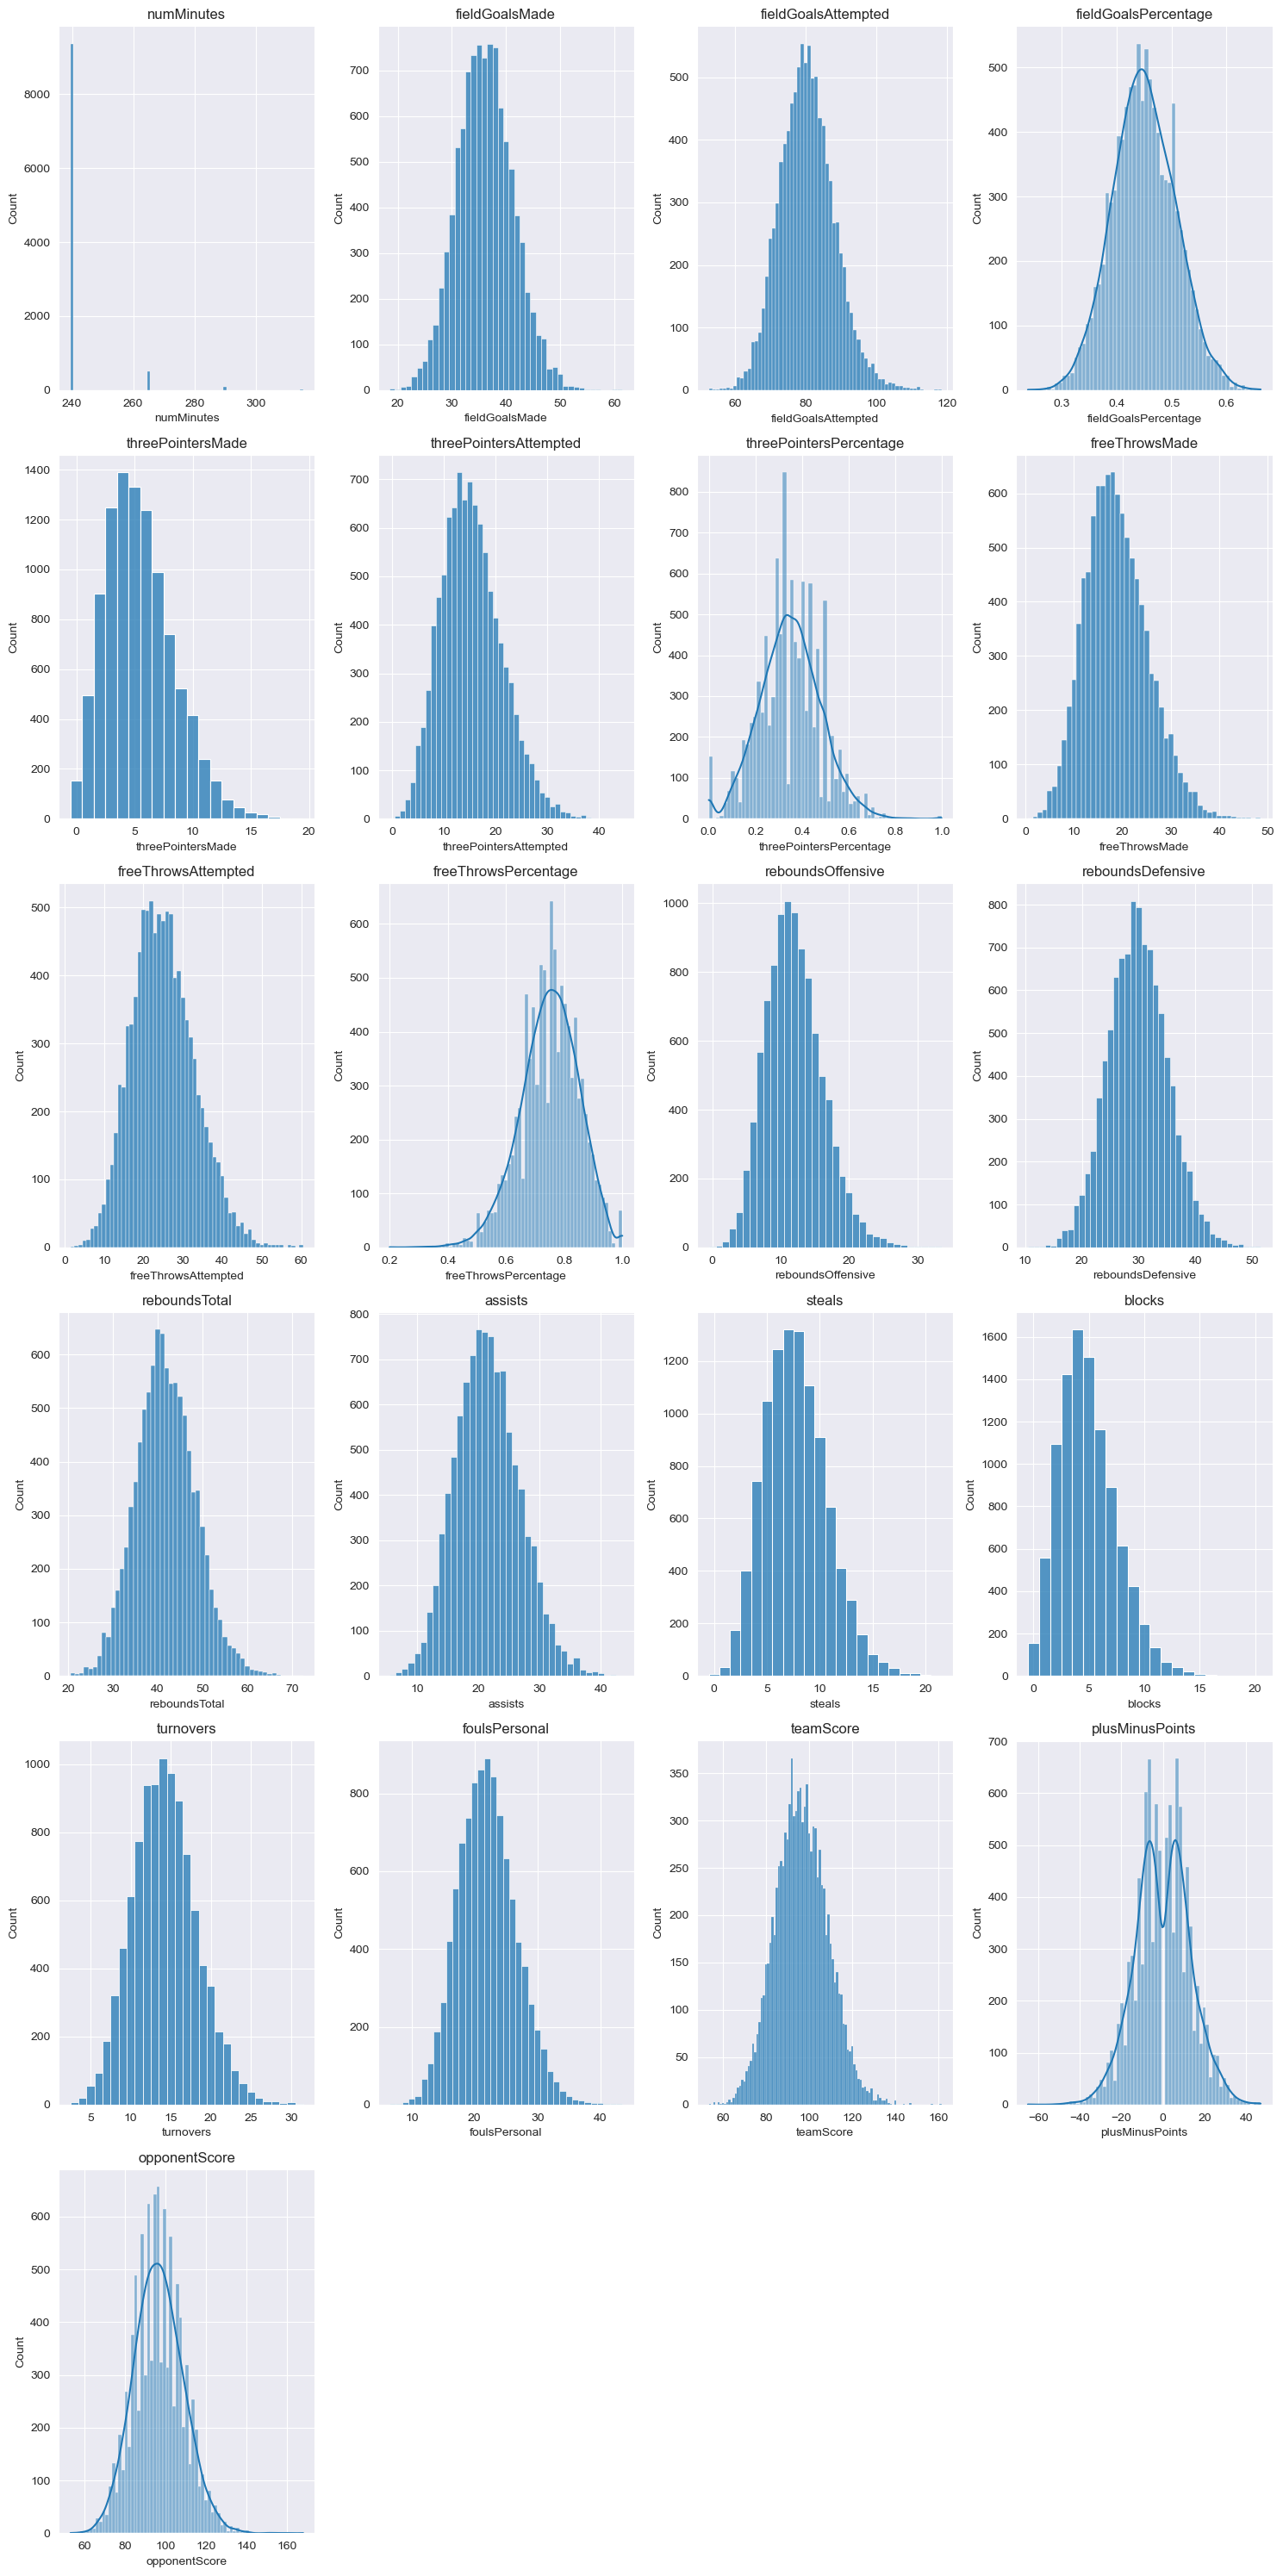

In [70]:
from pandas.api.types import is_integer_dtype

plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot) // 4 + 1, 4, i + 1)
    if is_integer_dtype(hist_regular_season_team_df[column]):
        sns.histplot(hist_regular_season_team_df[column], kde=False, discrete=True) # Use discrete=True for integer data
    else:
        sns.histplot(hist_regular_season_team_df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

Players.csv

#  Players.csv

In [ ]:
players_df = pd.read_csv("/content/Players.csv")

In [ ]:
players_df.head()

In [ ]:
# @title height

from matplotlib import pyplot as plt
players_df['height'].plot(kind='hist', bins=20, title='height')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in team_statistics_df.columns:
    dtype = team_statistics_df[col].dtype
    missing = team_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = team_statistics_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = team_statistics_df[col].min()
        max_val = team_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")

In [ ]:
game_type_df = player_statistics_df[['gameId', 'gameType']].drop_duplicates()
team_statistics_df = team_statistics_df.merge(game_type_df, on='gameId', how='left')
team_statistics_df.head()

In [ ]:
# Redo column description
team_statistics_df.head()
# Detailed column overview with dtype, value range/examples, and missing values
print("Detailed column overview:\n")
for col in team_statistics_df.columns:
    dtype = team_statistics_df[col].dtype
    missing = team_statistics_df[col].isnull().sum()

    if dtype == 'object':
        example_values = team_statistics_df[col].dropna().unique()[:3]  # Show a few example values
        # print in an output has left justfied columns, each of 100 characters width
        examples = f"Examples: {str(list(example_values))}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {examples:<80} | Missing: {missing:>10} |")
    else:
        min_val = team_statistics_df[col].min()
        max_val = team_statistics_df[col].max()
        r = f"Range: {min_val} to {max_val}"
        print(f"| {str(col):<30} | {str(dtype):>10} | {r:<80} | Missing: {missing:>10} |")

In [ ]:
# print all unique values for gameType
print("Unique values for gameType:")
print(team_statistics_df['gameType'].unique())

In [ ]:
# divide data into the groups of the game type; 'Regular Season' 'Preseason' 'Playoffs' 'Play-in Tournament' 'NBA Cup' 'NBA Emirates Cup'
regular_season_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Regular Season']
preseason_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Preseason']
playoffs_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Playoffs']
play_in_tournament_team_df = team_statistics_df[team_statistics_df['gameType'] == 'Play-in Tournament']
nba_cup_team_df = team_statistics_df[team_statistics_df['gameType'] == 'NBA Cup']
nba_emirates_cup_team_df = team_statistics_df[team_statistics_df['gameType'] == 'NBA Emirates Cup']

In [ ]:
# print nr of entries for each of the groups (new df's)
print("Nr of entries for each of the groups (new df's):")
print("Regular Season:", len(regular_season_team_df))
print("Preseason:", len(preseason_team_df))
print("Playoffs:", len(playoffs_team_df))
print("Play-in Tournament:", len(play_in_tournament_team_df))
print("NBA Cup:", len(nba_cup_team_df))
print("NBA Emirates Cup:", len(nba_emirates_cup_team_df))
regular_season_team_df.head()

In [ ]:
regular_season_team_df = regular_season_team_df.drop(columns=[
    'gameDate', 'teamCity', 'teamName', 'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'coachId', 'gameType'
])
regular_season_team_df.head()

In [ ]:
regular_season_team_df.info()

In [ ]:
# Subset of Regular Season
sub_regular_season_team_df = regular_season_team_df.sample(n=10000, random_state=2)
sub_regular_season_team_df.info()

In [ ]:
# Pairplot
# sns.pairplot(sub_regular_season_team_df)

In [ ]:
columns_to_plot = sub_regular_season_team_df.columns
# Create the boxplots
plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot) // 4 + 1, 4, i + 1)
    sns.boxplot(y=column, data=sub_regular_season_team_df)
    plt.title(column)
plt.tight_layout()
plt.show()

In [ ]:
# a correlation matrix on columns to plot
corr_matrix = sub_regular_season_team_df[columns_to_plot].corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
from pandas.api.types import is_integer_dtype

# Create histograms
hist_regular_season_team_df = sub_regular_season_team_df.drop(columns=[
    'gameId', 'teamId', 'home', 'win'
    ])
columns_to_plot = hist_regular_season_team_df.columns

plt.figure(figsize=(15, 30))
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot) // 4 + 1, 4, i + 1)
    if is_integer_dtype(hist_regular_season_team_df[column]):
        sns.histplot(hist_regular_season_team_df[column], kde=False, discrete=True) # Use discrete=True for integer data
    else:
        sns.histplot(hist_regular_season_team_df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()